In [3]:
import tensorflow as tf
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.models import Sequential
from google.colab import files
files.upload()
print(tf.__version__)

Saving USD_IDR Historical Data.csv to USD_IDR Historical Data.csv
2.3.0


In [4]:
#Link dataset from https://www.investing.com/currencies/usd-idr-historical-data pada tanggal 22 Oktober 2012 sampai
#dengan 28 Agustus 2020
import io
df = pd.read_csv("/content/USD_IDR Historical Data.csv", parse_dates=['Date'])
df

,Date,Price,Open,High,Low,Change %
0,2020-08-28,"14,615.0","14,655.0","14,716.5","14,614.5",-0.24%
1,2020-08-27,"14,650.0","14,605.0","14,727.5","14,605.0",-0.14%
2,2020-08-26,"14,670.0","14,585.0","14,695.0","14,585.0",0.20%
3,2020-08-25,"14,640.0","14,600.0","14,660.0","14,575.0",-0.20%
4,2020-08-24,"14,670.0","14,755.0","14,802.5","14,670.5",-0.68%
...,...,...,...,...,...,...
2033,2012-10-26,"9,605.0","9,605.0","9,605.0","9,605.0",0.00%
2034,2012-10-25,"9,605.0","9,620.0","9,620.0","9,605.0",-0.05%
2035,2012-10-24,"9,610.0","9,610.0","9,615.0","9,605.0",0.03%
2036,2012-10-23,"9,607.5","9,602.5","9,612.5","9,602.5",0.03%


In [5]:
#Reference from https://plotly.com/python/time-series/
fig = px.line(df, x='Date', y='Price', title='Mata uang rupiah terhadap dollar AS')
fig.show()

from sklearn.model_selection import train_test_split

date = df['Date'].values
price = df[['Price']].replace({',':''}, regex=True)
price = price.astype('float32')
price = price.values
price_train, price_test, date_train, date_test = train_test_split(price, date, test_size=0.2, shuffle=False)

print(price_train.shape, date_train.shape)
print(price_test.shape, date_test.shape)

(1630, 1) (1630,)
(408, 1) (408,)


In [6]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
#Link referensi : https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb

priceTrain = windowed_dataset(price_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
priceTest = windowed_dataset(price_test, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(LSTM(32, recurrent_dropout=0.9, return_sequences=True)),
        tf.keras.layers.LSTM(16, recurrent_dropout=0.9, return_sequences=True),
        tf.keras.layers.LSTM(8),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
])

model.summary()

model.compile(loss = tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.SGD(lr=1.000e-04, momentum=0.9, decay=0.01), metrics = ['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          5184      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [8]:
a = price.max()
print(a)
b = price.min()
print(b)
mae = (price.max() - price.min()) * 0.1
print(mae)

16575.0
9593.5
698.1500000000001


In [10]:
history = model.fit(priceTrain, epochs=25, verbose=2)

Epoch 1/25
7/7 - 4s - loss: 615.2733 - mae: 611.6172
Epoch 2/25
7/7 - 4s - loss: 628.0006 - mae: 626.0264
Epoch 3/25
7/7 - 4s - loss: 621.9349 - mae: 622.4287
Epoch 4/25
7/7 - 4s - loss: 655.8535 - mae: 658.6263
Epoch 5/25
7/7 - 4s - loss: 660.2094 - mae: 659.7913
Epoch 6/25
7/7 - 4s - loss: 697.5928 - mae: 697.4648
Epoch 7/25
7/7 - 4s - loss: 724.2261 - mae: 725.5380
Epoch 8/25
7/7 - 4s - loss: 668.9905 - mae: 667.8649
Epoch 9/25
7/7 - 4s - loss: 615.9684 - mae: 615.3583
Epoch 10/25
7/7 - 4s - loss: 628.3536 - mae: 626.6285
Epoch 11/25
7/7 - 4s - loss: 698.6844 - mae: 697.1766
Epoch 12/25
7/7 - 4s - loss: 654.0737 - mae: 654.7017
Epoch 13/25
7/7 - 4s - loss: 635.3145 - mae: 639.3308
Epoch 14/25
7/7 - 4s - loss: 616.3325 - mae: 613.2662
Epoch 15/25
7/7 - 4s - loss: 630.9152 - mae: 629.1439
Epoch 16/25
7/7 - 4s - loss: 662.4688 - mae: 660.5417
Epoch 17/25
7/7 - 4s - loss: 698.5853 - mae: 700.9200
Epoch 18/25
7/7 - 4s - loss: 606.3316 - mae: 606.3246
Epoch 19/25
7/7 - 4s - loss: 630.1459

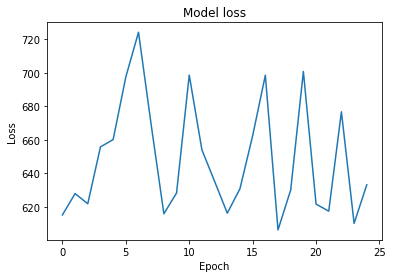

In [11]:
plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

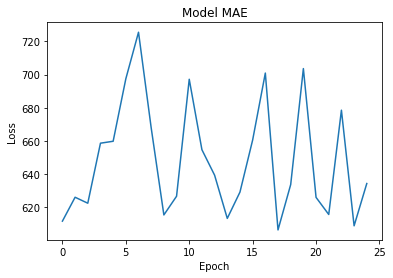

In [12]:
plt.plot(model.history.history['mae'])
plt.title('Model MAE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()